In [1]:

import os
from torch.optim import AdamW

In [2]:

from transformers import VideoMAEFeatureExtractor, VideoMAEForVideoClassification
from decord import VideoReader, cpu

/storage/home/hcoda1/3/ryendapalli3/.conda/envs/exist2025/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

import torch
import pandas as pd
import pickle
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score













In [4]:
class TikTokVideoDataset(Dataset):
    def __init__(self, df, video_dir, feature_extractor, num_frames=16):
        self.video_dir = video_dir
        self.feature_extractor = feature_extractor
        self.num_frames = num_frames
        self.valid_rows = []

        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Checking videos"):
            video_path = os.path.join(video_dir, row['video'])
            try:
                vr = VideoReader(video_path, ctx=cpu(0))
                if len(vr) >= num_frames:
                    self.valid_rows.append(row)
            except:
                continue

        self.df = pd.DataFrame(self.valid_rows).reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_path = os.path.join(self.video_dir, row['video'])
        try:
            vr = VideoReader(video_path, ctx=cpu(0))
            total_frames = len(vr)
            indices = torch.linspace(0, total_frames - 1, self.num_frames).long().tolist()
            video = vr.get_batch(indices).asnumpy()
            inputs = self.feature_extractor([frame for frame in video], return_tensors="pt")
            pixel_values = inputs["pixel_values"].squeeze(0)
            label = int(row['target'])
            return {"pixel_values": pixel_values, "labels": torch.tensor(label)}
        except:
            return None

def skip_none_collate(batch):
    batch = [x for x in batch if x is not None]
    if len(batch) == 0:
        return None
    return torch.utils.data.default_collate(batch)

In [5]:
test_path = "/storage/coda1/p-dsgt_clef2025/0/shared/exist/latest/EXIST_2025_Videos_Dataset/train_test/test_df.csv"
val_path = "/storage/coda1/p-dsgt_clef2025/0/shared/exist/latest/EXIST_2025_Videos_Dataset/train_test/valid_df.csv"
train_path = "/storage/coda1/p-dsgt_clef2025/0/shared/exist/latest/EXIST_2025_Videos_Dataset/train_test/train_df.csv"
video_dir = "/storage/coda1/p-dsgt_clef2025/0/shared/exist/latest/EXIST_2025_Videos_Dataset/training/videos"

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

feature_extractor = VideoMAEFeatureExtractor.from_pretrained("MCG-NJU/videomae-base")

/storage/home/hcoda1/3/ryendapalli3/.conda/envs/exist2025/lib/python3.12/site-packages/transformers/models/videomae/feature_extraction_videomae.py:28: FutureWarning: The class VideoMAEFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use VideoMAEImageProcessor instead.
  warnings.warn(


In [6]:
def get_or_create_dataset(cache_file, df, video_dir, feature_extractor, num_frames=16):
    if os.path.exists(cache_file):
        print(f"Loading cached dataset: {cache_file}")
        with open(cache_file, "rb") as f:
            return pickle.load(f)
    else:
        print(f"Building and caching dataset: {cache_file}")
        dataset = TikTokVideoDataset(df, video_dir, feature_extractor, num_frames)
        with open(cache_file, "wb") as f:
            pickle.dump(dataset, f)
        return dataset

train_dataset = get_or_create_dataset("cached_train_dataset.pkl", train_df, video_dir, feature_extractor)
val_dataset = get_or_create_dataset("cached_val_dataset.pkl", val_df, video_dir, feature_extractor)
test_dataset = get_or_create_dataset("cached_test_dataset.pkl", test_df, video_dir, feature_extractor)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=8,
                          pin_memory=True, prefetch_factor=2, collate_fn=skip_none_collate, persistent_workers=True)

val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=8,
                          pin_memory=True, prefetch_factor=2, collate_fn=skip_none_collate, persistent_workers=True)

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=8,
                         pin_memory=True, prefetch_factor=2, collate_fn=skip_none_collate, persistent_workers=True)


Loading cached dataset: cached_train_dataset.pkl
Loading cached dataset: cached_val_dataset.pkl
Loading cached dataset: cached_test_dataset.pkl


In [7]:
def evaluate_model(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in data_loader:
            if batch is None:
                continue
            inputs = batch["pixel_values"].to(model.device)
            labels = batch["labels"].to(model.device)

            outputs = model(pixel_values=inputs)
            loss = torch.nn.CrossEntropyLoss()(outputs.logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    avg_loss = total_loss / len(data_loader)
    return avg_loss, acc, f1


In [8]:
import copy
import csv

def run_experiment(freeze_type, lr, dropout, trial_name, bestest_f1):
    print(f"\nRunning {trial_name} | freeze={freeze_type}, lr={lr}, dropout={dropout}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = VideoMAEForVideoClassification.from_pretrained("MCG-NJU/videomae-base", num_labels=2)

    if freeze_type == "all":
        for param in model.videomae.parameters():
            param.requires_grad = False
    elif freeze_type == "last3":
        for param in model.videomae.parameters():
            param.requires_grad = False
        for block in model.videomae.encoder.layer[-3:]:
            for param in block.parameters():
                param.requires_grad = True
    elif freeze_type == "none":
        for param in model.videomae.parameters():
            param.requires_grad = True


    import torch.nn as nn
    model.dropout = nn.Dropout(dropout)
    original_forward = model.forward
    def patched_forward(*args, **kwargs):
        out = original_forward(*args, **kwargs)
        out.logits = model.dropout(out.logits)
        return out
    model.forward = patched_forward

    model.to(device)

    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    best_f1 = 0
    patience = 3
    wait = 0

    epoch_stats = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "val_f1": [],
    }

    for epoch in range(10):
        model.train()
        train_preds, train_labels = [], []
        total_train_loss = 0

        for batch in train_loader:
            if batch is None:
                continue
            inputs = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(pixel_values=inputs)
            loss = criterion(outputs.logits, labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_train_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_acc = accuracy_score(train_labels, train_preds)
        train_f1 = f1_score(train_labels, train_preds, average="macro")
        train_loss_avg = total_train_loss / len(train_loader)

        test_loss, test_acc, test_f1 = evaluate_model(model, test_loader)

        print(
            f"Epoch {epoch+1}: "
            f"Train Loss = {train_loss_avg:.4f}, Train Acc = {train_acc:.4f}, "
            f"Test Loss = {test_loss:.4f}, Test Acc = {test_acc:.4f}, F1 Macro = {test_f1:.4f}"
        )

        epoch_stats["epoch"].append(epoch + 1)
        epoch_stats["train_loss"].append(train_loss_avg)
        epoch_stats["train_acc"].append(train_acc)
        epoch_stats["val_loss"].append(test_loss)
        epoch_stats["val_acc"].append(test_acc)
        epoch_stats["val_f1"].append(test_f1)


        if test_f1 > best_f1:
            best_f1 = test_f1
            wait = 0
            if best_f1 > bestest_f1:
                bestest_f1 = best_f1
                torch.save(model.state_dict(), "best_model_finetuned.pt")
                print("New bestest F1 found, saving model")
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping.")
                break
  
    import pandas as pd
    df = pd.DataFrame(epoch_stats)
    df.to_csv(f"{trial_name}_epoch_metrics.csv", index=False)
    print(f"Saved epoch-wise metrics to {trial_name}_epoch_metrics.csv")

    return {
        "trial": trial_name,
        "freeze": freeze_type,
        "lr": lr,
        "dropout": dropout,
        "train_acc": train_acc,
        "test_acc": test_acc,
        "f1_macro": test_f1,
        "epochs_run": epoch + 1,
        "bestest_f1": bestest_f1
    }


In [9]:
experiments = [
    # ("all",    2e-5, 0.3, "baseline"),
    # ("last3",  1e-5, 0.3, "tune_last3"),
    # ("last3",  1e-4, 0.3, "fast_head"),
    # ("last3",  1e-5, 0.5, "high_dropout"),
    # ("last6",  1e-5, 0.3, "deeper_unfreeze"),  
    # ("none",   5e-6, 0.3, "full_finetune")
    ("last6",  5e-5, 0.3, "high_lr"),
    ("last6",  1e-5, 0.5, "high_dropout"),
    ("last6",  5e-5, 0.5, "high_lr_dropout"),
]

results = []
bestest_f1 = 0
for freeze, lr, drop, name in experiments:
    result = run_experiment(freeze, lr, drop, name, bestest_f1)
    bestest_f1 = result["bestest_f1"]
    results.append(result)

# Save to CSV
keys = results[0].keys()
with open("sweep_results.csv", "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=keys)
    writer.writeheader()
    writer.writerows(results)

print("\n Saved all results to sweep_results.csv")



Running high_lr | freeze=last6, lr=5e-05, dropout=0.3


Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Train Loss = 0.7239, Train Acc = 0.5626, Test Loss = 0.6944, Test Acc = 0.5333, F1 Macro = 0.3997
New bestest F1 found, saving model
Epoch 2: Train Loss = 0.6715, Train Acc = 0.5901, Test Loss = 0.7155, Test Acc = 0.4769, F1 Macro = 0.3742
Epoch 3: Train Loss = 0.6084, Train Acc = 0.6621, Test Loss = 0.7151, Test Acc = 0.5436, F1 Macro = 0.5419
New bestest F1 found, saving model
Epoch 4: Train Loss = 0.5447, Train Acc = 0.7033, Test Loss = 0.8562, Test Acc = 0.5179, F1 Macro = 0.4882
Epoch 5: Train Loss = 0.4887, Train Acc = 0.7290, Test Loss = 0.7999, Test Acc = 0.5641, F1 Macro = 0.5624
New bestest F1 found, saving model
Epoch 6: Train Loss = 0.4254, Train Acc = 0.7959, Test Loss = 0.9298, Test Acc = 0.5846, F1 Macro = 0.5802
New bestest F1 found, saving model
Epoch 7: Train Loss = 0.4124, Train Acc = 0.8010, Test Loss = 0.8639, Test Acc = 0.4615, F1 Macro = 0.4546
Epoch 8: Train Loss = 0.3363, Train Acc = 0.8250, Test Loss = 1.1897, Test Acc = 0.5026, F1 Macro = 0.5017
Epoc

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Train Loss = 0.7210, Train Acc = 0.5266, Test Loss = 0.6899, Test Acc = 0.5436, F1 Macro = 0.5387
Epoch 2: Train Loss = 0.6192, Train Acc = 0.6569, Test Loss = 0.6670, Test Acc = 0.5282, F1 Macro = 0.5261
Epoch 3: Train Loss = 0.5339, Train Acc = 0.7290, Test Loss = 0.6821, Test Acc = 0.5692, F1 Macro = 0.5620
Epoch 4: Train Loss = 0.4400, Train Acc = 0.7907, Test Loss = 0.7086, Test Acc = 0.5641, F1 Macro = 0.5360
Epoch 5: Train Loss = 0.3411, Train Acc = 0.8302, Test Loss = 0.7167, Test Acc = 0.5692, F1 Macro = 0.5691
Epoch 6: Train Loss = 0.2490, Train Acc = 0.8714, Test Loss = 0.8141, Test Acc = 0.5538, F1 Macro = 0.5491
Epoch 7: Train Loss = 0.2489, Train Acc = 0.8714, Test Loss = 0.9444, Test Acc = 0.5385, F1 Macro = 0.4986
Epoch 8: Train Loss = 0.2495, Train Acc = 0.8645, Test Loss = 0.8958, Test Acc = 0.5385, F1 Macro = 0.5231
Early stopping.
Saved epoch-wise metrics to high_dropout_epoch_metrics.csv

Running high_lr_dropout | freeze=last6, lr=5e-05, dropout=0.5


Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Train Loss = 0.7486, Train Acc = 0.4957, Test Loss = 0.7059, Test Acc = 0.4872, F1 Macro = 0.4739
Epoch 2: Train Loss = 0.7003, Train Acc = 0.5489, Test Loss = 0.7100, Test Acc = 0.4974, F1 Macro = 0.3988


In [13]:
# import torch.nn as nn

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = VideoMAEForVideoClassification.from_pretrained("MCG-NJU/videomae-base", num_labels=2)

# for param in model.videomae.parameters():
#     param.requires_grad = False

# for block in model.videomae.encoder.layer[-3:]:
#     for param in block.parameters():
#         param.requires_grad = True

# #TODO: Dropout

# model.dropout = nn.Dropout(p=0.3)
# original_forward = model.forward

# def patched_forward(*args, **kwargs):
#     out = original_forward(*args, **kwargs)
#     out.logits = model.dropout(out.logits)
#     return out

# model.forward = patched_forward
# model.to(device)

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VideoMAEForVideoClassification(
  (videomae): VideoMAEModel(
    (embeddings): VideoMAEEmbeddings(
      (patch_embeddings): VideoMAEPatchEmbeddings(
        (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
      )
    )
    (encoder): VideoMAEEncoder(
      (layer): ModuleList(
        (0-11): 12 x VideoMAELayer(
          (attention): VideoMAEAttention(
            (attention): VideoMAESelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
            )
            (output): VideoMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): VideoMAEIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
    

In [14]:
from torch.optim import AdamW
# from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
# scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)
criterion = torch.nn.CrossEntropyLoss()

def evaluate_model(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            if batch is None:
                continue
            inputs = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(pixel_values=inputs)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    avg_loss = total_loss / len(data_loader)
    return avg_loss, acc, f1

In [15]:
# best_f1 = 0
# patience = 7
# wait = 0

# train_losses, train_accuracies = [], []
# val_losses, val_accuracies, f1_macros = [], [], []

# for epoch in range(20):
#     print(f"\n Epoch {epoch + 1}")
#     model.train()
#     total_train_loss = 0
#     train_preds, train_labels = [], []

#     for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} Batches"):
#         if batch is None:
#             continue
#         inputs = batch["pixel_values"].to(device)
#         labels = batch["labels"].to(device)

#         outputs = model(pixel_values=inputs)
#         loss = criterion(outputs.logits, labels)

#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#         total_train_loss += loss.item()

#         preds = torch.argmax(outputs.logits, dim=1)
#         train_preds.extend(preds.cpu().numpy())
#         train_labels.extend(labels.cpu().numpy())

#     train_acc = accuracy_score(train_labels, train_preds)
#     train_f1 = f1_score(train_labels, train_preds, average="macro")
#     train_loss_avg = total_train_loss / len(train_loader)

#     val_loss, val_acc, val_f1 = evaluate_model(model, val_loader)

#     print(
#         f"Epoch {epoch + 1}: "
#         f"Train Loss = {train_loss_avg:.4f}, Train Acc = {train_acc:.4f}, "
#         f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}, F1 Macro = {val_f1:.4f}"
#     )

#     train_losses.append(train_loss_avg)
#     train_accuracies.append(train_acc)
#     val_losses.append(val_loss)
#     val_accuracies.append(val_acc)
#     f1_macros.append(val_f1)

#     # scheduler.step()

#     if val_f1 > best_f1:
#         best_f1 = val_f1
#         wait = 0
#         torch.save(model.state_dict(), "best_model.pt")
#     else:
#         wait += 1
#         if wait >= patience:
#             print("Early stopping triggered.")
#             break


 Epoch 1


Epoch 1 Batches: 100%|██████████| 146/146 [02:13<00:00,  1.10it/s]


Epoch 1: Train Loss = 0.7273, Train Acc = 0.5352, Val Loss = 0.6887, Val Acc = 0.5641, F1 Macro = 0.5038

 Epoch 2


Epoch 2 Batches: 100%|██████████| 146/146 [01:54<00:00,  1.28it/s]


Epoch 2: Train Loss = 0.5864, Train Acc = 0.6758, Val Loss = 0.7300, Val Acc = 0.5692, F1 Macro = 0.5349

 Epoch 3


Epoch 3 Batches: 100%|██████████| 146/146 [01:54<00:00,  1.28it/s]


Epoch 3: Train Loss = 0.3350, Train Acc = 0.8473, Val Loss = 0.9247, Val Acc = 0.5333, F1 Macro = 0.5316

 Epoch 4


Epoch 4 Batches: 100%|██████████| 146/146 [01:54<00:00,  1.28it/s]


Epoch 4: Train Loss = 0.1539, Train Acc = 0.9211, Val Loss = 1.5772, Val Acc = 0.5231, F1 Macro = 0.5115

 Epoch 5


Epoch 5 Batches: 100%|██████████| 146/146 [01:54<00:00,  1.27it/s]


Epoch 5: Train Loss = 0.1014, Train Acc = 0.9520, Val Loss = 1.3928, Val Acc = 0.5487, F1 Macro = 0.5453

 Epoch 6


Epoch 6 Batches: 100%|██████████| 146/146 [01:56<00:00,  1.25it/s]


Epoch 6: Train Loss = 0.1038, Train Acc = 0.9468, Val Loss = 1.8057, Val Acc = 0.6000, F1 Macro = 0.5922

 Epoch 7


Epoch 7 Batches: 100%|██████████| 146/146 [01:54<00:00,  1.27it/s]


Epoch 7: Train Loss = 0.1014, Train Acc = 0.9485, Val Loss = 1.6509, Val Acc = 0.5744, F1 Macro = 0.5654

 Epoch 8


Epoch 8 Batches: 100%|██████████| 146/146 [01:53<00:00,  1.29it/s]


Epoch 8: Train Loss = 0.0692, Train Acc = 0.9657, Val Loss = 1.9294, Val Acc = 0.5795, F1 Macro = 0.5776

 Epoch 9


Epoch 9 Batches: 100%|██████████| 146/146 [01:54<00:00,  1.28it/s]


Epoch 9: Train Loss = 0.0474, Train Acc = 0.9760, Val Loss = 2.1618, Val Acc = 0.5949, F1 Macro = 0.5612

 Epoch 10


Epoch 10 Batches: 100%|██████████| 146/146 [01:53<00:00,  1.29it/s]


Epoch 10: Train Loss = 0.0617, Train Acc = 0.9537, Val Loss = 2.2803, Val Acc = 0.5744, F1 Macro = 0.5444

 Epoch 11


Epoch 11 Batches: 100%|██████████| 146/146 [01:54<00:00,  1.28it/s]


Epoch 11: Train Loss = 0.0721, Train Acc = 0.9520, Val Loss = 2.3834, Val Acc = 0.5795, F1 Macro = 0.5558

 Epoch 12


Epoch 12 Batches: 100%|██████████| 146/146 [01:55<00:00,  1.27it/s]


Epoch 12: Train Loss = 0.0647, Train Acc = 0.9588, Val Loss = 2.4869, Val Acc = 0.5795, F1 Macro = 0.5558

 Epoch 13


Epoch 13 Batches: 100%|██████████| 146/146 [01:54<00:00,  1.27it/s]


Epoch 13: Train Loss = 0.0706, Train Acc = 0.9485, Val Loss = 2.5698, Val Acc = 0.5846, F1 Macro = 0.5623
Early stopping triggered.


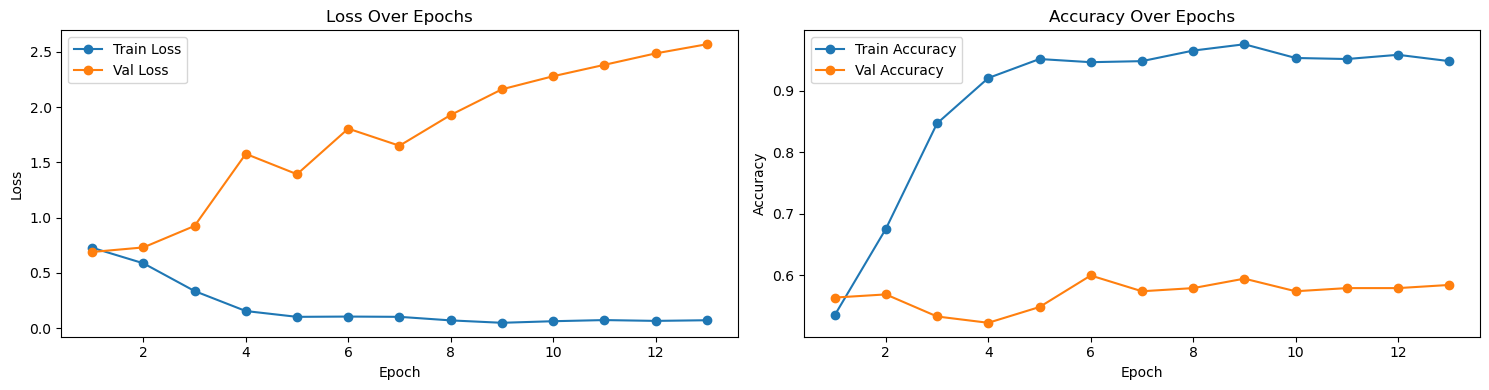

In [16]:
# import matplotlib.pyplot as plt

# epochs = list(range(1, len(train_losses) + 1))

# plt.figure(figsize=(15, 4))

# plt.subplot(1, 2, 1)
# plt.plot(epochs, train_losses, label="Train Loss", marker='o')
# plt.plot(epochs, val_losses, label="Val Loss", marker='o')
# plt.title("Loss Over Epochs")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(epochs, train_accuracies, label="Train Accuracy", marker='o')
# plt.plot(epochs, val_accuracies, label="Val Accuracy", marker='o')
# plt.title("Accuracy Over Epochs")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.legend()

# plt.tight_layout()
# plt.show()


In [15]:
# model.load_state_dict(torch.load("best_model.pt"))
# model.eval()


NameError: name 'model' is not defined

In [18]:
# import torch
# import pandas as pd
# import numpy as np
# from tqdm import tqdm

# def generate_predictions(model, dataloader):
#     model.eval()
#     all_probs = []
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for batch in tqdm(dataloader, desc="Generating Predictions"):
#             if batch is None:
#                 continue

#             inputs = batch["pixel_values"].to(device)
#             labels = batch["labels"].to(device)

#             outputs = model(pixel_values=inputs)
#             probs = torch.softmax(outputs.logits, dim=1)

#             all_probs.extend(probs.cpu().numpy())
#             all_preds.extend(torch.argmax(probs, dim=1).cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     return np.array(all_probs), np.array(all_preds), np.array(all_labels)


In [19]:
# # Get predictions
# probs, preds, labels = generate_predictions(model, test_loader)

# test_acc = accuracy_score(labels, preds)
# test_f1 = f1_score(labels, preds, average="macro")

# print(f"Test Accuracy: {test_acc:.4f}")
# print(f"Test Macro F1 Score: {test_f1:.4f}")

# # Build a DataFrame
# df = pd.DataFrame({
#     "true_label": labels,
#     "pred_label": preds,
#     "prob_class_0": probs[:, 0],
#     "prob_class_1": probs[:, 1]
# })

# # Optionally add video filenames
# if hasattr(test_dataset, "df") and "video" in test_dataset.df.columns:
#     df["video"] = test_dataset.df["video"]

# # Save to CSV
# df.to_csv("test_predictions.csv", index=False)
# print("Saved predictions to test_predictions.csv")


Generating Predictions: 100%|██████████| 49/49 [00:35<00:00,  1.39it/s]

Test Accuracy: 0.6051
Test Macro F1 Score: 0.6050
Saved predictions to test_predictions.csv


In [18]:
# Generating plots and final predictions to csv from a saved model
#
#
#

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VideoMAEForVideoClassification.from_pretrained("MCG-NJU/videomae-base", num_labels=2)
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
model.to(device)

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VideoMAEForVideoClassification(
  (videomae): VideoMAEModel(
    (embeddings): VideoMAEEmbeddings(
      (patch_embeddings): VideoMAEPatchEmbeddings(
        (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
      )
    )
    (encoder): VideoMAEEncoder(
      (layer): ModuleList(
        (0-11): 12 x VideoMAELayer(
          (attention): VideoMAEAttention(
            (attention): VideoMAESelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
            )
            (output): VideoMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): VideoMAEIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
    

In [19]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd
from tqdm import tqdm

def generate_predictions(model, dataloader, dataset_name=""):
    model.eval()
    all_probs = []
    all_preds = []
    all_labels = []
    video_ids = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Generating {dataset_name} predictions"):
            if batch is None:
                continue
            inputs = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(pixel_values=inputs)
            probs = torch.softmax(outputs.logits, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(torch.argmax(probs, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_probs), np.array(all_preds), np.array(all_labels)


In [20]:
probs_train, preds_train, labels_train = generate_predictions(model, train_loader, "train")
probs_val, preds_val, labels_val = generate_predictions(model, val_loader, "val")
probs_test, preds_test, labels_test = generate_predictions(model, test_loader, "test")


Generating test predictions: 100%|██████████| 49/49 [00:35<00:00,  1.40it/s]


In [21]:
def print_metrics(name, preds, labels):
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    print(f"{name} Accuracy: {acc:.4f}, Macro F1: {f1:.4f}")

print_metrics("Train", preds_train, labels_train)
print_metrics("Val", preds_val, labels_val)
print_metrics("Test", preds_test, labels_test)


Train Accuracy: 0.9022, Macro F1: 0.9019
Val Accuracy: 0.5538, Macro F1: 0.5500
Test Accuracy: 0.6154, Macro F1: 0.6153


In [22]:
import pandas as pd

def export_predictions_csv(probs, preds, labels, dataset, name):
    # Get filenames from the dataset
    if hasattr(dataset, "df") and "video" in dataset.df.columns:
        video_names = dataset.df["video"].tolist()
    else:
        video_names = [f"video_{i}.mp4" for i in range(len(preds))]

    df = pd.DataFrame({
        "video": video_names,
        "true_label": labels,
        "predicted_label": preds,
        "prob_class_0": probs[:, 0],
        "prob_class_1": probs[:, 1]
    })

    df.to_csv(f"{name}_predictions.csv", index=False)
    print(f"Saved {name}_predictions.csv")

# Call for each dataset
export_predictions_csv(probs_train, preds_train, labels_train, train_dataset, "train")
export_predictions_csv(probs_val, preds_val, labels_val, val_dataset, "val")
export_predictions_csv(probs_test, preds_test, labels_test, test_dataset, "test")


Saved train_predictions.csv
Saved val_predictions.csv
Saved test_predictions.csv


In [23]:
train_losses = [0.7104, 0.5915, 0.4324, 0.2382, 0.1695]
train_accuracies = [0.5077, 0.6981, 0.8422, 0.9245, 0.9331]
val_losses = [0.7238, 0.6648, 0.7195, 0.7652, 0.8809]  # test used as val
val_accuracies = [0.5077, 0.6154, 0.5538, 0.5487, 0.5641]
f1_macros = [0.4372, 0.6153, 0.5105, 0.5337, 0.5641]


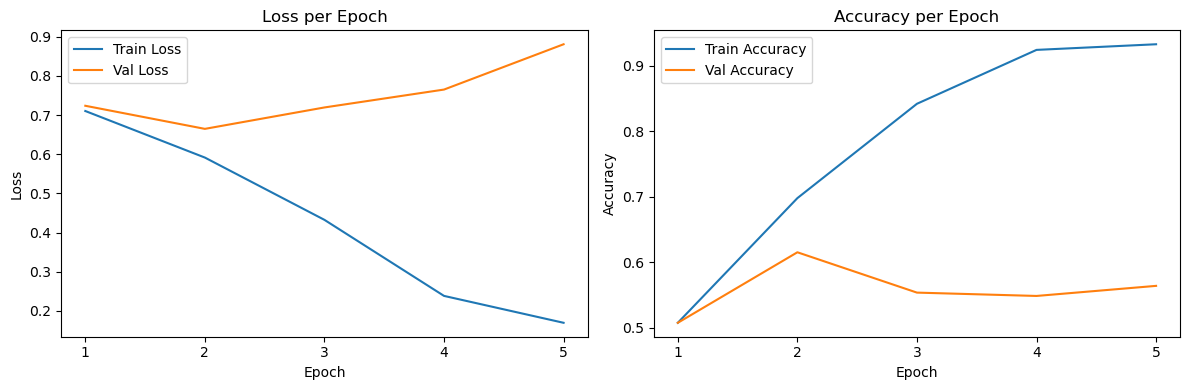

In [25]:
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator  # for the alternative method

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.xticks(epochs)  # only whole numbers
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.xticks(epochs)  # only whole numbers
plt.legend()

plt.tight_layout()
plt.show()
